# Analysing the posterior distributions for sentiment analysis of tweets in Portuguese

[Back to the index](00_index.ipynb)

In this notebook we applied the method to the analysis of emotions annotated on tweets in Portuguese. The idea is to identify emotions whose occurence is associated with the occurence of other emotions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import re
import json
from glob import glob
import matplotlib_venn as vn

import mcmc as am
import data_retriever as xz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Functions

In [2]:
def chain_file_to_stats_df(filename):
    """
    Load an MCMC chain stored in a CSV file directly into 
    a summary statistics DataFrame.
    """
    # Get features names:
    match = re.search('[A-Z]+\-[A-Z]+', filename)
    if match is not None:
        pair = match[0].split('-')
    
    df = am.create_stats_summary_df(pd.read_csv(filename), pair[0], pair[1])
    
    return df

In [3]:
def stat_significant_df(stats_df, global_significance):
    """
    """
    
    # Select statistically significant data:
    relevant_df = stats_df.loc[stats_df['s p-value'] < global_significance].sort_values('sP(A|B)').copy()
    
    # Create an ID for the sentiment pair:
    relevant_df['pair_id'] = relevant_df['A'] + relevant_df['B']
    relevant_df['pair_id'].where(relevant_df['A'] < relevant_df['B'], relevant_df['B'] + relevant_df['A'], inplace=True)

    # Add columns for plotting (label and columns):
    relevant_df['label'] = relevant_df['B'] + ' $\rightarrow$ ' + relevant_df['A']
    relevant_df.loc[relevant_df['sP(A|B)'] < 0, 'color'] = 'firebrick'
    relevant_df.loc[relevant_df['sP(A|B)'] > 0, 'color'] = 'royalblue'
        
    return relevant_df

In [4]:
def sel_one_way(relevant_df):
    """
    When sP(A|B) is significant, sP(B|A) is too.
    Select the largest effect of the two.
    """
    
    # If one way is statistically significant, the other one is as well.
    assert set(relevant_df['A'] + relevant_df['B']) == set(relevant_df['B'] + relevant_df['A'])

    # Select just the strongest of the sentiment pairs:
    one_way_df = relevant_df.loc[relevant_df['sP(A|B)'].abs().sort_values(ascending=False).index].copy()
    one_way_df = one_way_df.drop_duplicates(subset='pair_id', keep='first').sort_values('sP(A|B)')
    
    return one_way_df

In [5]:
def plot_prob_gain(relevant_df):

    pl.barh(relevant_df['label'], relevant_df['sP(A|B)'], left=relevant_df['P(A)'], color=relevant_df['color'], alpha=0.6)
    #pl.axvline(0, color='0.7', linewidth=1)
    #pl.axvline(0.5, color='0.7', linestyle='--', linewidth=1)
    pl.errorbar(relevant_df['P(A|B)'], relevant_df['label'], xerr=relevant_df['dev P(A|B)'], fmt='none', ecolor=relevant_df['color'])
    pl.xlim([0,1])
    pl.xlabel('Probability', fontsize=13)


In [6]:
def annotation_matrix_show(df, cmap, label, fignum=None, vmin=None, vmax=None):
    """
    Create a colormap for a matrix.
    
    Parameters
    ----------
    df : DataFrame
        Matrix to plot. It is expected that all columns contains numbers.
    cmap : str
        Matplotlib colormap to be used (e.g. 'Greens', 'Coolwarm').
    label : str
        Label for the colorbar (i.e. what the numbers in the matrix correspond
        to).
    fignum : int or None
        The number of the figure in which to create the plot (if the Figure 
        was already created). If None, create a new Figure.
    vmin : float or None
        Mininum value in the color scale.
    vmax : float or None
        Maximum value in the color scale.
    """
    cols = df.columns
    rows = df.index
    
    pl.matshow(df, cmap=cmap, vmin=vmin, vmax=vmax, fignum=fignum)
    pl.xticks(ticks=range(len(cols)), labels=cols, rotation=90)
    pl.yticks(ticks=range(len(rows)), labels=rows)
    ax = pl.gca()
    pl.tick_params(labelsize=10)
    ax.xaxis.set_label_position('top')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = pl.colorbar(cax=cax)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_ylabel(label, fontsize=11)
    
    pl.sca(ax)

## Load data

In [7]:
emotion_cols = ['ABORRECIMENTO', 'ADMIRACAO', 'ALEGRIA', 'ALIVIO', 'AMOR', 'APROVACAO', 'COMPRAIXAO', 'CONFUSAO', 'CURIOSIDADE', 'DECEPCAO', 
                'DESAPROVACAO', 'DESEJO', 'DIVERSAO', 'ENTUSIASMO', 'GRATIDAO', 'INVEJA', 'LUTO', 'MEDO', 'NERVOSISMO', 'EMONEUTRO', 'NOJO',
                'ORGULHO', 'OTIMISMO', 'RAIVA', 'REMORSO', 'SAUDADE', 'SCHADENFREUDE', 'SURPRESA', 'TRISTEZA', 'VERGONHA']

In [8]:
# Download chains (if not present):
xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/9pSQBbmW9qHJ9iW/download/emo.zip', '../data/chains/', keep_zip_dir=False)

# List chains:
emo_chain_files   = sorted(glob('../data/chains/emo/*.csv'))

# Gets statistical summary from chains:
emo_stats_df   = pd.concat([chain_file_to_stats_df(f) for f in emo_chain_files], ignore_index=True)

Found a local file, skip download.


In [9]:
# Load categories translation:
with open('../data/cleaned/translations_emo.json', 'r') as f:
    emo_translation = json.load(f)

### Select statistically relevant results

In [10]:
single_significance = 0.02
n_classes = len(emotion_cols)
n_comparisons = n_classes * (n_classes - 1) / 2
global_significance = single_significance / n_comparisons
print('# comparisons:', n_comparisons)

# comparisons: 435.0


In [11]:
emo_relevant_df = stat_significant_df(emo_stats_df, global_significance)

## Analysing chains

# pairs: 48


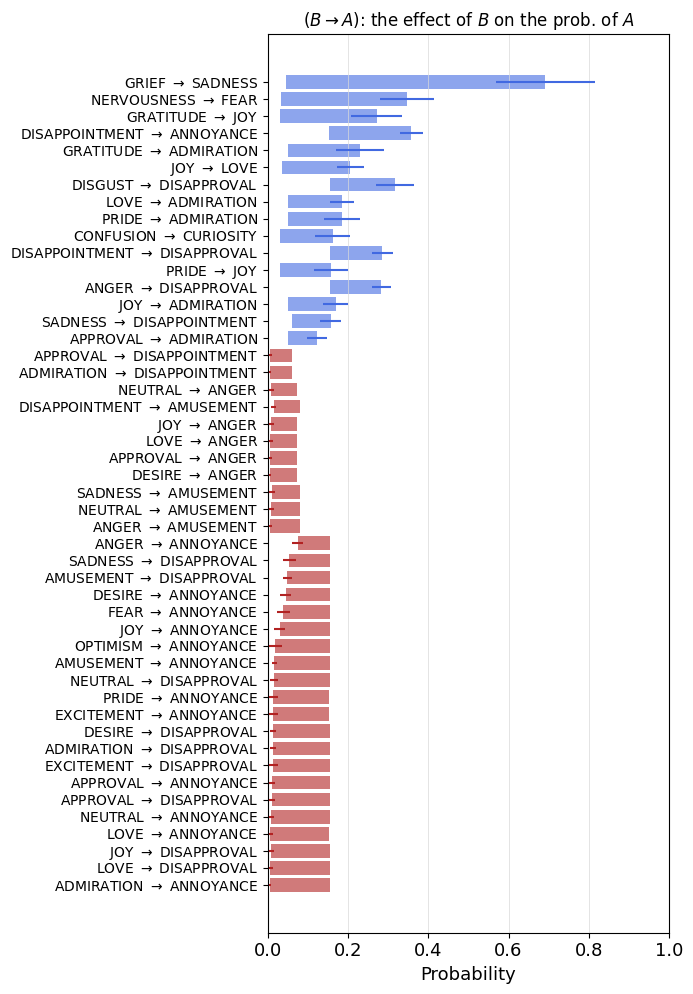

In [26]:
one_way_df = sel_one_way(emo_relevant_df)
print('# pairs:', len(one_way_df))

pl.figure(figsize=(7,10))
one_way_df['A'] = one_way_df['A'].map(emo_translation)
one_way_df['B'] = one_way_df['B'].map(emo_translation)
one_way_df['label'] = one_way_df['B'] + r' $\rightarrow$ ' + one_way_df['A']
plot_prob_gain(one_way_df)
pl.title(r'($B \rightarrow A$): the effect of $B$ on the prob. of $A$')
pl.tight_layout()
ax = pl.gca()
ax.xaxis.set_tick_params(labelsize=13)
pl.grid(axis='x', color='0.85', linewidth=0.5, zorder=-10)
# Set y-axis tick labels bold
#for label in ax.get_yticklabels():
#  label.set_weight('bold')

#pl.savefig('plots/prob-boost-sentiments.png', bbox_inches='tight')
pl.show()

### Interesting cases

In [202]:
emo_relevant_df.query('(A == "TRISTEZA" and B == "LUTO") or (B == "TRISTEZA" and A == "LUTO")')

,Direction,A,B,P(A),dev P(A),P(A|B),dev P(A|B),sP(A|B),dev sP(A|B),abs s nsigma,s p-value,pair_id,label,color
730,F,LUTO,TRISTEZA,0.002829,0.000781,0.044274,0.014314,0.041445,0.013688,3.02793,0.0,LUTOTRISTEZA,TRISTEZA $\rightarrow$ LUTO,royalblue
731,B,TRISTEZA,LUTO,0.044191,0.003022,0.691840,0.122520,0.647649,0.122216,5.29922,0.0,LUTOTRISTEZA,LUTO $\rightarrow$ TRISTEZA,royalblue


In [185]:
one_way_df.query('A == "SADNESS" and B == "GRIEF"')

,Direction,A,B,P(A),dev P(A),P(A|B),dev P(A|B),sP(A|B),dev sP(A|B),abs s nsigma,s p-value,pair_id,label,color
731,B,SADNESS,GRIEF,0.044191,0.003022,0.69184,0.12252,0.647649,0.122216,5.29922,0.0,LUTOTRISTEZA,GRIEF $\rightarrow$ SADNESS,royalblue


In [186]:
one_way_df.query('A == "CURIOSITY"')

,Direction,A,B,P(A),dev P(A),P(A|B),dev P(A|B),sP(A|B),dev sP(A|B),abs s nsigma,s p-value,pair_id,label,color
365,B,CURIOSITY,CONFUSION,0.031181,0.002576,0.16197,0.044133,0.130789,0.04356,3.002471,0.0,CONFUSAOCURIOSIDADE,CONFUSION $\rightarrow$ CURIOSITY,royalblue


In [183]:
repulsions_df = one_way_df.query('`sP(A|B)` < 0')
exclusive_dist = (repulsions_df['P(A|B)'] / repulsions_df['dev P(A|B)'])
repulsions_df.loc[exclusive_dist.loc[exclusive_dist > 3].sort_values(ascending=False).index]

,Direction,A,B,P(A),dev P(A),P(A|B),dev P(A|B),sP(A|B),dev sP(A|B),abs s nsigma,s p-value,pair_id,label,color
44,F,ANNOYANCE,ANGER,0.153798,0.005314,0.074396,0.014293,-0.079402,0.014236,5.577634,0.0,ABORRECIMENTORAIVA,ANGER $\rightarrow$ ANNOYANCE,firebrick
492,F,DISAPPROVAL,AMUSEMENT,0.155288,0.005338,0.048764,0.011214,-0.106524,0.011576,9.202023,0.0,DESAPROVACAODIVERSAO,AMUSEMENT $\rightarrow$ DISAPPROVAL,firebrick
524,F,DISAPPROVAL,SADNESS,0.155305,0.005326,0.053767,0.015528,-0.101538,0.015746,6.448462,0.0,DESAPROVACAOTRISTEZA,SADNESS $\rightarrow$ DISAPPROVAL,firebrick
20,F,ANNOYANCE,DESIRE,0.153789,0.005319,0.045011,0.013908,-0.108779,0.014282,7.616480,0.0,ABORRECIMENTODESEJO,DESIRE $\rightarrow$ ANNOYANCE,firebrick


### Venn diagrams

In [55]:
# Loading annotated tweets:
summ_df = pd.read_csv('../data/processed/emo-moral_v1_anotador_summarized.csv', sep=';')
# Emotion x emotion (fully and correctly annotated data):
emoemo_df = summ_df.query('annotated_1 * annotated_2 * annotated_3 == 1')

In [200]:
len(emoemo_df)

4613

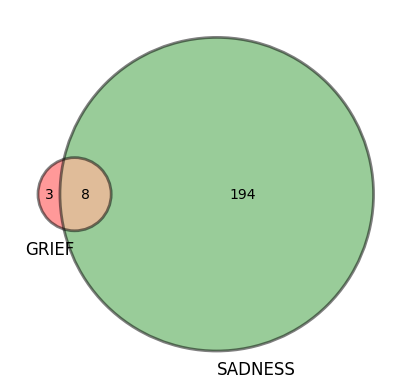

In [199]:
emo_pair = ['LUTO', 'TRISTEZA']
labels   = ['GRIEF', 'SADNESS']
pair_df = emoemo_df[emo_pair]
obs_counts = am.count_onehot_pairs(pair_df)
vn.venn2(subsets=(obs_counts[0][2], obs_counts[0][1], obs_counts[0][3]), set_labels=labels)
vn.venn2_circles(subsets=(obs_counts[0][2], obs_counts[0][1], obs_counts[0][3]), alpha=0.5, linewidth=2)
#pl.savefig('plots/venn_grief_sadness.png', bbox_inches='tight')
pl.show()

### Contingency tables

In [208]:
pd.crosstab(emoemo_df['ADMIRACAO'], emoemo_df['ALEGRIA'], margins=True)

ALEGRIA,0,1,All
ADMIRACAO,,,
0,4274,112,4386
1,205,22,227
All,4479,134,4613


## Independent emotions

In [35]:
# Select indepedent emotion pairs:
indep_df = emo_stats_df.loc[(emo_stats_df['s p-value'] > 0.16)].copy()

# Create an ID for the sentiment pair:
indep_df['pair_id'] = indep_df['A'] + indep_df['B']
indep_df['pair_id'].where(indep_df['A'] < indep_df['B'], indep_df['B'] + indep_df['A'], inplace=True)

# Sanity check: 
assert set(indep_df['A'] + indep_df['B']) == set(indep_df['B'] + indep_df['A'])

# Select cases with low error:
indep_df = indep_df.loc[indep_df['dev sP(A|B)'] < 0.02]
# Select pair that all permutations have low error:
indep_df = indep_df.loc[indep_df.duplicated(subset='pair_id', keep=False)]

In [47]:
check_cols = ['A', 'B', 'P(A)', 'sP(A|B)', 'dev sP(A|B)']
indep_df.sort_values('dev sP(A|B)', ascending=False).drop_duplicates(subset='pair_id', keep='first').sort_values('P(A)', ascending=False)

,Direction,A,B,P(A),dev P(A),P(A|B),dev P(A|B),sP(A|B),dev sP(A|B),abs s nsigma,s p-value,pair_id
79,B,DIVERSAO,ADMIRACAO,0.079905,0.003993,0.065260,0.016272,-0.014644,0.015953,0.917952,0.174500,ADMIRACAODIVERSAO
76,F,ADMIRACAO,DESEJO,0.049594,0.003188,0.063383,0.016412,0.013790,0.015904,0.867052,0.195850,ADMIRACAODESEJO
233,B,DESEJO,AMOR,0.048102,0.003173,0.036892,0.014546,-0.011209,0.014399,0.778500,0.203300,AMORDESEJO
560,F,DESEJO,TRISTEZA,0.048086,0.003173,0.039329,0.013693,-0.008757,0.013424,0.652361,0.236075,DESEJOTRISTEZA
868,F,TRISTEZA,VERGONHA,0.044193,0.003020,0.032629,0.018541,-0.011564,0.018401,0.628447,0.230450,TRISTEZAVERGONHA
221,B,APROVACAO,AMOR,0.038775,0.002832,0.049438,0.016906,0.010663,0.016535,0.644911,0.278825,AMORAPROVACAO
272,F,APROVACAO,CONFUSAO,0.038742,0.002840,0.029281,0.020036,-0.009461,0.019952,0.474202,0.260925,APROVACAOCONFUSAO
238,F,AMOR,ENTUSIASMO,0.035091,0.002716,0.026172,0.018185,-0.008919,0.018054,0.494028,0.253325,AMORENTUSIASMO
268,F,AMOR,VERGONHA,0.035085,0.002711,0.021514,0.014859,-0.013570,0.014823,0.915486,0.161700,AMORVERGONHA
756,F,MEDO,VERGONHA,0.033353,0.002644,0.033078,0.018652,-0.000275,0.018475,0.014884,0.424525,MEDOVERGONHA


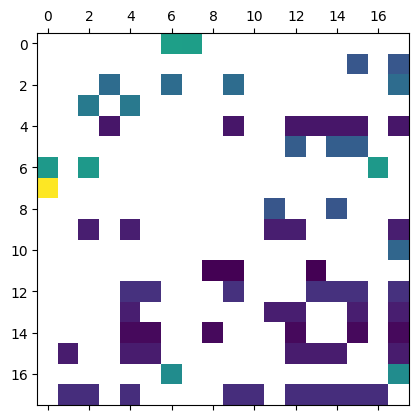

In [46]:
pl.matshow(indep_df.pivot(index='A', columns='B', values='P(A)'));

### Example

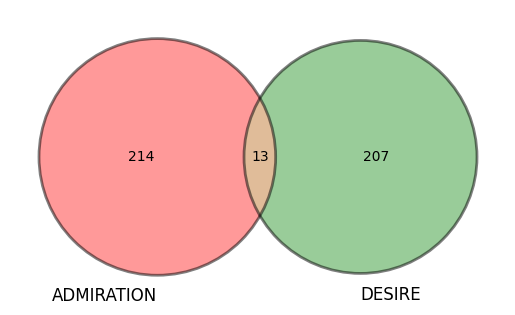

In [57]:
emo_pair = ['ADMIRACAO', 'DESEJO']
labels   = ['ADMIRATION', 'DESIRE']
pair_df = emoemo_df[emo_pair]
obs_counts = am.count_onehot_pairs(pair_df)
vn.venn2(subsets=(obs_counts[0][2], obs_counts[0][1], obs_counts[0][3]), set_labels=labels)
vn.venn2_circles(subsets=(obs_counts[0][2], obs_counts[0][1], obs_counts[0][3]), alpha=0.5, linewidth=2)
#pl.savefig('plots/venn_grief_sadness.png', bbox_inches='tight')
pl.show()

In [50]:
chain_file = list(filter(lambda s: s.find('ADMIRACAO') != -1 and s.find('DESEJO') != -1, emo_chain_files))[0]
ex_chain_df = pd.read_csv(chain_file)

In [53]:
ex_chain_df.head()

,p00,p01,p10,p11,Pa,Pb,P(a|b),P(a|~b),P(b|a),P(b|~a),sPa,sPb
0,0.901148,0.049589,0.045897,0.003366,0.049264,0.052955,0.063569,0.048464,0.068332,0.052158,0.014306,0.015378
1,0.908112,0.044121,0.043968,0.003799,0.047767,0.047920,0.079280,0.046181,0.079533,0.046334,0.031513,0.031613
2,0.906953,0.042947,0.048377,0.001724,0.050101,0.044670,0.038586,0.050639,0.034404,0.045212,-0.011515,-0.010267
3,0.905097,0.043408,0.049186,0.002309,0.051495,0.045717,0.050500,0.051542,0.044834,0.045765,-0.000995,-0.000883
4,0.905941,0.042485,0.048162,0.003412,0.051574,0.045897,0.074340,0.050479,0.066157,0.044795,0.022767,0.020261


<Axes: >

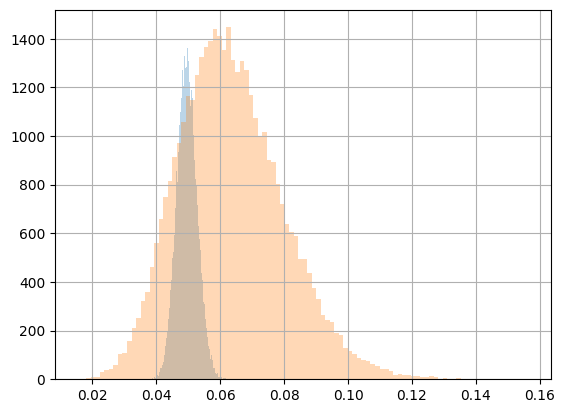

In [63]:
ex_chain_df['Pa'].hist(bins=100, alpha=0.3)
ex_chain_df['P(a|b)'].hist(bins=100, alpha=0.3)

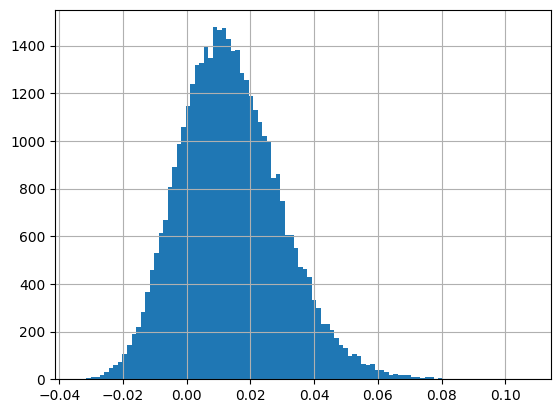

In [60]:
#ex_chain_df['Pa'].hist(bins=100);
ex_chain_df['sPa'].hist(bins=100);

In [65]:
len(emoemo_df)

4613